In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import interpolate

sys.path.append(os.path.join('..'))
from model import GreyboxModel

# load experiment parameters
exptname = 'predator-prey'
trialname = 'demo'
mode = 'adaptive'
with open(os.path.join('..', 'params.yaml'), 'r') as fd:
    params = yaml.safe_load(fd)

### Preparation

In [2]:
# load raw data
tables_list = []
with np.load(os.path.join('..', 'out', 'data_raw.npz')) as data:
    for i in range(1,11):
        tables_list.append(data['C%d'%i])

# interpolation
tables_interpolated_list = []
for table in tables_list:
    table = table[~np.isnan(table).any(axis=1)] # eliminate rows with nan
    interp = interpolate.interp1d(table[:,0], table[:,1:], kind='linear', axis=0)
    first = np.ceil(table[0,0])
    last = np.floor(table[-1,0])
    t_interpolated = np.linspace(first, last, int(last-first)+1)
    tables_interpolated_list.append(
        np.concatenate([t_interpolated[:,np.newaxis], interp(t_interpolated)], axis=1)
    )
tables_list = tables_interpolated_list

# load model
model = GreyboxModel(params['model'])
model.load_state_dict(torch.load(os.path.join('..', 'out', trialname, mode, 'model_te.pt')))
model.eval()

GreyboxModel(
  (net_fD): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
  (net_zD_encoder): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=16, bias=True)
  )
  (net_thT_encoder): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): Leak

### Apply model on sequence

Text(0, 0.5, 'nrmse')

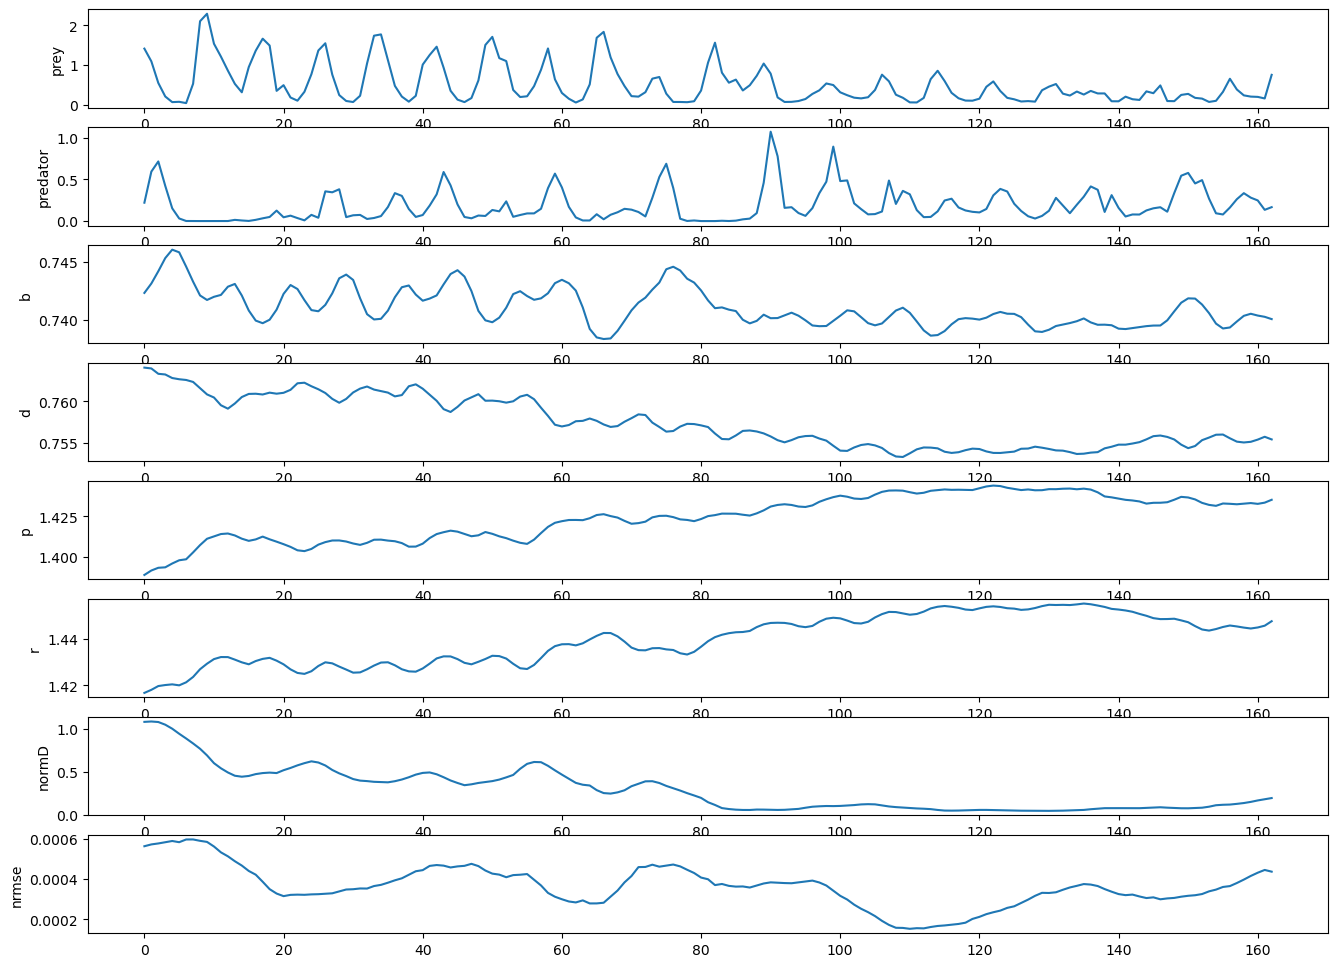

In [3]:
# sequence index
data_idx = 7

data = tables_list[data_idx]
data_max = np.max(data)
data_min = np.min(data)
x = []
R = []
thT = []
nrmse = []
for i in range(data.shape[0]):
    if i+params['model']['num_steps_x'] > data.shape[0]:
        break
    _x = torch.tensor(data[i:i+params['model']['num_steps_x'],1:]).float().view(1,-1,2)
    _yh, _R = model(_x)
    _thT = model.thT_encode(_x)
    _nrmse = torch.sqrt(torch.pow(_yh - _x[:,1:], 2).mean()) / (data_max - data_min)
    x.append(_x)
    R.append(_R.item())
    thT.append(_thT)
    nrmse.append(_nrmse.item())
x = torch.cat(x, dim=0).detach().numpy()
R = np.array(R)
thT = torch.cat(thT, dim=0).detach().numpy()
nrmse = np.array(nrmse)

# moving average
ma_weight = np.ones(params['model']['num_steps_x'])/params['model']['num_steps_x']
thT_ma = []
for i in range(4):
    thT_ma.append(np.convolve(thT[:,i], ma_weight, 'valid')[:,np.newaxis])
thT_ma = np.concatenate(thT_ma, axis=1)
R_ma = np.convolve(R, ma_weight, 'valid')
nrmse_ma = np.convolve(nrmse, ma_weight, 'valid')

# plot
fig, axes = plt.subplots(8, 1, figsize=(16,12))
axes[0].plot(data[:thT_ma.shape[0],1]); axes[0].set_ylabel('prey')
axes[1].plot(data[:thT_ma.shape[0],2]); axes[1].set_ylabel('predator')
axes[2].plot(thT_ma[:,0]); axes[2].set_ylabel('b')
axes[3].plot(thT_ma[:,1]); axes[3].set_ylabel('d')
axes[4].plot(thT_ma[:,2]); axes[4].set_ylabel('p')
axes[5].plot(thT_ma[:,3]); axes[5].set_ylabel('r')
axes[6].plot(R_ma); axes[6].set_ylabel('normD')
axes[7].plot(nrmse_ma); axes[7].set_ylabel('nrmse')

save
np.savetxt('../../predator-prey_C%d.txt' % data_idx,
    np.concatenate((
        data[:thT_ma.shape[0]],
        thT_ma,
        R_ma[:,np.newaxis],
        nrmse_ma[:,np.newaxis]*100.0
    ), axis=1),
    header='t prey predator b d p r normD nrmse_prc',
    comments='',
    fmt='%.3e'
)

### See R map for particular timestamp

In [ ]:
data_idx = 7
timestamp = 65

_x = torch.tensor(tables_list[data_idx][timestamp:timestamp+params['model']['num_steps_x'],1:]).float().view(1,-1,2)

K = 11
ax = [[],[],[],[]]
ax[0] = np.linspace(0.0, 1.0, K) # b: prey's growth rate w/o interaction (alpha)
ax[1] = np.linspace(0.0, 1.0, K) # d: predator's decay rate w/o interaction (gamma)
ax[2] = np.linspace(0.0, 2.0, K) # p: prey's decay rate by predation (beta)
ax[3] = np.linspace(0.0, 2.0, K) # r: predator's growth rate by predation (delta)

# TODO: parallelize!
nrmse = torch.empty(K, K, K, K)
R = torch.empty(K, K, K, K)
for i in range(K):
    for j in range(K):
        for k in range(K):
            for l in range(K):
                _yh, _R = model(_x, thT=torch.tensor([ax[0][i],ax[1][j],ax[2][k],ax[3][l]]).float().view(1,4))
                _nrmse = torch.sqrt(torch.pow(_yh - _x[:,1:], 2).mean()) / (data_max - data_min)
                nrmse[i,j,k,l] = _nrmse.item()
                R[i,j,k,l] = _R.item()

In [ ]:
nominal_thT = model.thT_encode(_x).view(-1).detach().numpy()

# idx = np.unravel_index(R.argmin(), R.shape)
# nominal_thT = np.array([ax[i][idx[i]] for i in range(4)])

nidx = [0,0,0,0]
for i in range(4):
    nidx[i] = np.argmin(np.abs(ax[i] - nominal_thT[i]))

print(nominal_thT)

axnames = ['b', 'd', 'p', 'r']
targets_and_names = [(R,'normD'), (nrmse,'nrmse')]
for target, name in targets_and_names:
    for i,j in [(0,1), (0,2), (0,3), (2,1), (1,3), (2,3)]:
        _ax0, _ax1 = np.meshgrid(ax[i], ax[j])
        slices = [nidx[0], nidx[1], nidx[2], nidx[3]]
        slices[i] = slice(0, K)
        slices[j] = slice(0, K)
        plt.figure(figsize=(3.5,2.5))
        plt.contourf(_ax0, _ax1, target[slices[0], slices[1], slices[2], slices[3]], levels=16, cmap='viridis')
        # plt.plot(nominal_thT[i], nominal_thT[j], 'x', color='magenta')
        cb = plt.colorbar(); cb.set_ticks([])
        fname = 'predator-prey_%s_%s-%s.png'%(name, axnames[i], axnames[j])
        # plt.savefig(fname)
        print(fname)
        plt.show()
